https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html

https://microsoft.github.io/dowhy/example_notebooks/lalonde_pandas_api.html

# Collect data 📂

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score

df = pd.read_csv('../data/data.csv')
df

,treat,age,educ,race,married,nodegree,re74,re75,re78
0,1,37,11,black,1,1,0.00,0.00,9930.05
1,1,22,9,hispan,0,1,0.00,0.00,3595.89
2,1,30,12,black,0,0,0.00,0.00,24909.45
3,1,27,11,black,0,1,0.00,0.00,7506.15
4,1,33,8,black,0,1,0.00,0.00,289.79
...,...,...,...,...,...,...,...,...,...
609,0,18,11,white,0,1,0.00,0.00,10150.50
610,0,24,1,hispan,1,1,0.00,0.00,19464.61
611,0,21,18,white,0,0,0.00,0.00,0.00
612,0,32,5,black,1,1,0.00,0.00,187.67


## Prematching comparison

In [2]:
TREATMENT = 'treat'
OUTCOME = 're78'

df.groupby(TREATMENT)[OUTCOME].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.00,6984.17,7294.16,0.00,220.18,4975.51,11688.82,25564.67
1,185.00,6349.14,7867.40,0.00,485.23,4232.31,9643.00,60307.93


In [3]:
lm = LinearRegression()
lm.fit(df[[TREATMENT]], df[OUTCOME])
print(f"Intercept: {lm.intercept_:.2f}, Coefficient: {lm.coef_[0]:.2f}")

Intercept: 6984.17, Coefficient: -635.03


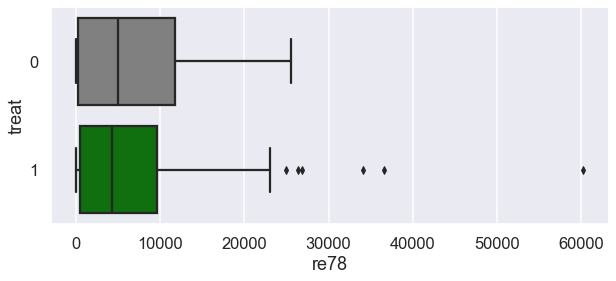

In [4]:
PALETTE = ['grey', 'green']

plt.figure(figsize=(10,4))
sns.boxplot(data=df, x=OUTCOME, y=TREATMENT, orient='h', palette=PALETTE);

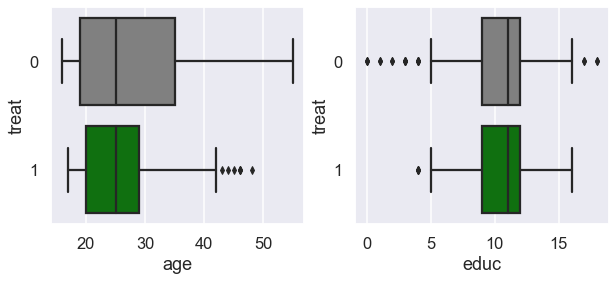

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
for i, var in enumerate(['age', 'educ']):
    sns.boxplot(data=df, x=var, y=TREATMENT, orient='h', palette=PALETTE, ax=ax[i]);

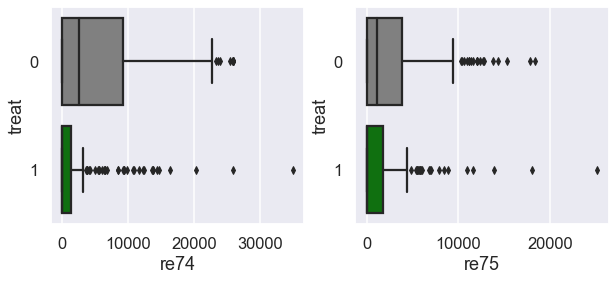

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
for i, var in enumerate(['re74', 're75']):
    sns.boxplot(data=df, x=var, y=TREATMENT, orient='h', palette=PALETTE, ax=ax[i]);

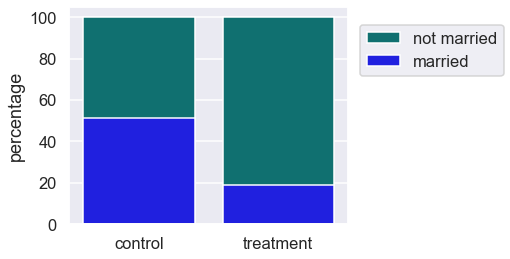

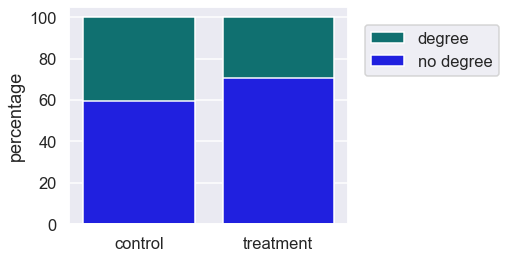

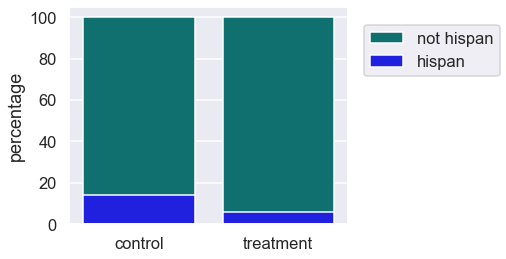

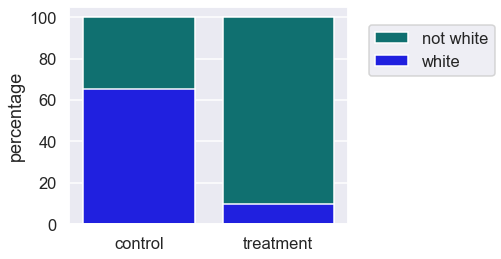

In [7]:
def plot_bar(df, var, labels):
    data = 100 * pd.crosstab(df[TREATMENT].replace({1: 'treatment', 
                                                    0: 'control'}), 
                             df[var], normalize='index')
    data['All'] = 100

    plt.figure(figsize=(5, 4))
    sns.barplot(data=data, x=data.index.astype(str),  y="All", 
                color='teal', label=labels[0])
    sns.barplot(data=data, x=data.index.astype(str),  y=1, 
                color='blue', label=labels[1])
    plt.legend(loc='center', bbox_to_anchor=(1.3, 0.8))
    plt.xlabel('')
    plt.ylabel('percentage');

binary = [['married', ['not married', 'married']], 
          ['nodegree', ['degree', 'no degree']],
          ['race_hispan', ['not hispan', 'hispan']],
          ['race_white', ['not white', 'white']]]

df_dummy = pd.get_dummies(df, drop_first=True)
for var, labels in binary:
    plot_bar(df_dummy, var, labels)

In [8]:
mapping = {0: 'control', 1: 'treatment'}
mean = df_dummy.groupby('treat').mean().T.rename(columns=mapping)
var = df_dummy.groupby('treat').var().T.rename(columns=mapping)
summary = mean.copy()
summary["cohen_d"] = (mean['treatment'] - mean['control'])/np.sqrt((var['treatment']+var['control'])/2)
summary["var_ratio"] = var['treatment']/var['control']
summary

treat,control,treatment,cohen_d,var_ratio
age,28.03,25.82,-0.24,0.44
educ,10.24,10.35,0.04,0.50
married,0.51,0.19,-0.72,0.62
nodegree,0.60,0.71,0.24,0.86
re74,5619.24,2095.57,-0.60,0.52
re75,2466.48,1532.06,-0.29,0.96
re78,6984.17,6349.14,-0.08,1.16
race_hispan,0.14,0.06,-0.28,0.46
race_white,0.66,0.10,-1.41,0.39


# Estimate propensity scores 🔨

In [9]:
# Build a descriptive model
t = df[TREATMENT]
X = pd.get_dummies(df.drop(columns=[OUTCOME, TREATMENT]))

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', LogisticRegression())
])
pipe.fit(X, t)

# Predict
threshold = 0.5
df['propensity'] = pipe.predict_proba(X)[:,1]
df['logit'] = df['propensity'].apply(lambda p: np.log(p/(1-p)))
df['pred'] = np.where(df['propensity']>=threshold, 1, 0)
df.head()

,treat,age,educ,race,married,nodegree,re74,re75,re78,propensity,logit,pred
0,1,37,11,black,1,1,0.00,0.00,9930.05,0.63,0.55,1
1,1,22,9,hispan,0,1,0.00,0.00,3595.89,0.22,-1.24,0
2,1,30,12,black,0,0,0.00,0.00,24909.45,0.68,0.74,1
3,1,27,11,black,0,1,0.00,0.00,7506.15,0.77,1.21,1
4,1,33,8,black,0,1,0.00,0.00,289.79,0.70,0.84,1


In [10]:
print(f"Accuracy: {np.mean(df[TREATMENT]==df['pred']):.4f},\
 ROC AUC: {roc_auc_score(df[TREATMENT], df['propensity']):.4f},\
 F1-score: {f1_score(df[TREATMENT], df['pred']):.4f}")

# Visualise confusion matrix
pd.crosstab(df[TREATMENT], df['pred'])

Accuracy: 0.8241, ROC AUC: 0.8743, F1-score: 0.7259


pred,0,1
treat,,
0,363,66
1,42,143


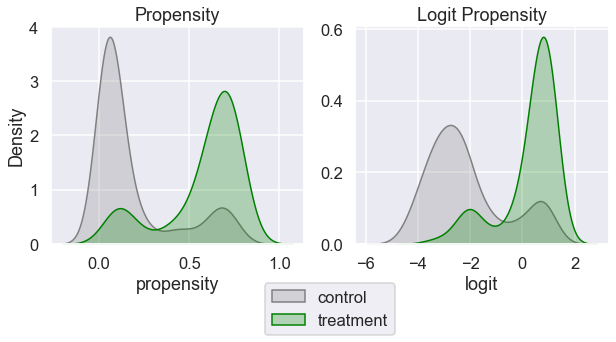

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
# Visualise propensity
sns.kdeplot(data=df[df[TREATMENT]==0], x='propensity', shade=True, 
            color=PALETTE[0], label=mapping[0], ax=ax[0])
sns.kdeplot(data=df[df[TREATMENT]==1], x='propensity', shade=True, 
            color=PALETTE[1], label=mapping[1], ax=ax[0])
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))

# Visualise logit propensity
sns.kdeplot(data=df[df[TREATMENT]==0], x='logit', shade=True, 
            color=PALETTE[0], label=mapping[0], ax=ax[1])
sns.kdeplot(data=df[df[TREATMENT]==1], x='logit', shade=True, 
            color=PALETTE[1], label=mapping[1], ax=ax[1])
ax[1].set_title('Logit Propensity')
ax[1].set_ylabel("");

# Match records 👀

In [12]:
# Sort by 'logit' so it's quicker to find match
df.sort_values('logit', inplace=True)
n = len(df)-1

for i, (ind, row) in enumerate(df.iterrows()): 
    # Match the most similar untreated record to each treated record
    if row[TREATMENT]:
        # Find the closest untreated match among records sorted 
        # higher. 'equal_or_above would' be more accurate but 
        # used 'above' for brevity        
        if i<n:
            above = df.iloc[i:]
            control_above = above[above[TREATMENT]==0]
            if len(control_above)>0:
                match_above = control_above.iloc[0]
                distance_above = match_above['logit'] - row['logit']
                df.loc[ind, 'match'] = match_above.name
                df.loc[ind, 'distance'] = distance_above
        
        # Find the closest untreated match among records sorted 
        # lower. 'equal_or_below' would be more accurate but 
        # used 'below' for brevity  
        if i>0:
            below = df.iloc[:i-1]
            control_below = below[below[TREATMENT]==0]
            if len(control_below)>0:
                match_below = control_below.iloc[-1]
                distance_below = match_below['logit'] - row['logit']
                if i==n:
                    df.loc[ind, 'match'] = match_below.name
                    df.loc[ind, 'distance'] = distance_below

                # Only overwrite if match_below is closer than match_above
                elif distance_below<distance_above:
                    df.loc[ind, 'match'] = match_below.name
                    df.loc[ind, 'distance'] = distance_below

df[df[TREATMENT]==1]

,treat,age,educ,race,married,nodegree,re74,re75,re78,propensity,logit,pred,match,distance
123,1,27,13,white,1,0,9381.57,853.72,0.00,0.03,-3.61,0,217.00,-0.01
136,1,23,8,white,1,1,0.00,1713.15,4232.31,0.04,-3.07,0,276.00,-0.02
9,1,33,12,white,1,0,0.00,0.00,12418.07,0.04,-3.07,0,293.00,-0.00
115,1,21,12,white,0,0,3670.87,334.05,12558.02,0.06,-2.67,0,605.00,-0.01
67,1,23,7,white,0,1,0.00,0.00,0.00,0.08,-2.49,0,298.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1,38,11,black,0,1,0.00,0.00,0.00,0.80,1.38,1,302.00,-0.09
78,1,40,11,black,0,1,0.00,0.00,23005.60,0.80,1.41,1,302.00,-0.12
175,1,28,11,black,0,1,1929.03,6871.86,0.00,0.81,1.44,1,302.00,-0.15
94,1,44,11,black,0,1,0.00,0.00,0.00,0.81,1.47,1,302.00,-0.18


In [13]:
indices = df[df['match'].notna()].index.\
          append(pd.Index(df.loc[df['match'].notna(), 'match']))
matched_df = df.loc[indices].reset_index(drop=True)
matched_df

,treat,age,educ,race,married,nodegree,re74,re75,re78,propensity,logit,pred,match,distance
0,1,27,13,white,1,0,9381.57,853.72,0.00,0.03,-3.61,0,217.00,-0.01
1,1,23,8,white,1,1,0.00,1713.15,4232.31,0.04,-3.07,0,276.00,-0.02
2,1,33,12,white,1,0,0.00,0.00,12418.07,0.04,-3.07,0,293.00,-0.00
3,1,21,12,white,0,0,3670.87,334.05,12558.02,0.06,-2.67,0,605.00,-0.01
4,1,23,7,white,0,1,0.00,0.00,0.00,0.08,-2.49,0,298.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,0,20,11,black,0,1,0.00,3480.39,5495.66,0.78,1.28,1,NaN,NaN
366,0,20,11,black,0,1,0.00,3480.39,5495.66,0.78,1.28,1,NaN,NaN
367,0,20,11,black,0,1,0.00,3480.39,5495.66,0.78,1.28,1,NaN,NaN
368,0,20,11,black,0,1,0.00,3480.39,5495.66,0.78,1.28,1,NaN,NaN


# Evaluate matching 🔍

In [14]:
COLUMNS = ['age', 'educ', 'race', 'married', 'nodegree', 're74', 're75', OUTCOME]
matches = pd.merge(df.loc[df[TREATMENT]==1, COLUMNS+['match']], 
                   df[COLUMNS], left_on='match', 
                   right_index=True, 
                   how='left', suffixes=('_t', '_c'))
matches

,age_t,educ_t,race_t,married_t,nodegree_t,re74_t,re75_t,re78_t,match,age_c,educ_c,race_c,married_c,nodegree_c,re74_c,re75_c,re78_c
123,27,13,white,1,0,9381.57,853.72,0.00,217.00,27,12,white,1,0,12270.89,7709.13,7806.83
136,23,8,white,1,1,0.00,1713.15,4232.31,276.00,22,11,white,1,1,8761.84,4463.27,10642.59
9,33,12,white,1,0,0.00,0.00,12418.07,293.00,21,15,white,1,0,6951.48,3879.63,0.00
115,21,12,white,0,0,3670.87,334.05,12558.02,605.00,55,8,white,1,1,0.00,0.00,0.00
67,23,7,white,0,1,0.00,0.00,0.00,298.00,28,8,hispan,1,1,8305.33,3718.50,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,38,11,black,0,1,0.00,0.00,0.00,302.00,20,11,black,0,1,0.00,3480.39,5495.66
78,40,11,black,0,1,0.00,0.00,23005.60,302.00,20,11,black,0,1,0.00,3480.39,5495.66
175,28,11,black,0,1,1929.03,6871.86,0.00,302.00,20,11,black,0,1,0.00,3480.39,5495.66
94,44,11,black,0,1,0.00,0.00,0.00,302.00,20,11,black,0,1,0.00,3480.39,5495.66


In [15]:
for var in ['logit', 're74']:
    print(f"{var} | Before matching")
    display(df.groupby(TREATMENT)[var].describe())
    print(f"{var} | After matching")
    display(matched_df.groupby(TREATMENT)[var].describe())

logit | Before matching


,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.00,-2.13,1.51,-4.61,-3.17,-2.47,-1.41,1.28
1,185.00,0.26,1.11,-3.61,0.12,0.63,0.96,1.69


logit | After matching


,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,185.00,0.22,1.11,-3.62,0.06,0.63,0.93,1.28
1,185.00,0.26,1.11,-3.61,0.12,0.63,0.96,1.69


re74 | Before matching


,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.00,5619.24,6788.75,0.00,0.00,2547.05,9277.13,25862.32
1,185.00,2095.57,4886.62,0.00,0.00,0.00,1291.47,35040.07


re74 | After matching


,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,185.00,2457.93,5132.47,0.00,0.00,0.00,1714.36,21918.32
1,185.00,2095.57,4886.62,0.00,0.00,0.00,1291.47,35040.07


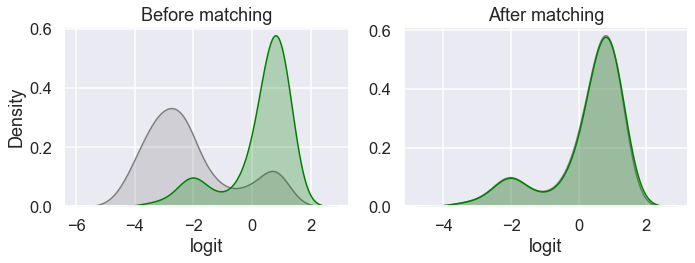

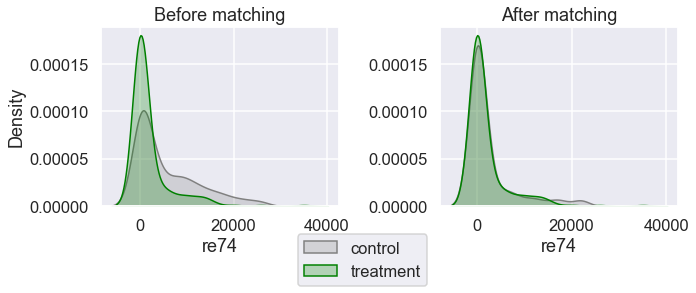

In [16]:
for var in ['logit', 're74']:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # Visualise original distribution
    sns.kdeplot(data=df[df[TREATMENT]==0], x=var, shade=True, 
                color=PALETTE[0], label=mapping[0], ax=ax[0])
    sns.kdeplot(data=df[df[TREATMENT]==1], x=var, shade=True, 
                color=PALETTE[1], label=mapping[1], ax=ax[0])
    ax[0].set_title('Before matching')
    
    # Visualise new distribution
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]==0], x=var, 
                shade=True, color=PALETTE[0], label=mapping[0], ax=ax[1])
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]==1], x=var, 
                shade=True, color=PALETTE[1], label=mapping[1], ax=ax[1])
    ax[1].set_title('After matching')
    ax[1].set_ylabel("")
    plt.tight_layout()
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3));

In [17]:
# print(f"{'is_female'} | Before matching")
# display(pd.crosstab(df[TREATMENT], df['is_female'], 
#                     normalize='index'))
# print(f"{'is_female'} | After matching")
# display(pd.crosstab(matched_df[TREATMENT], matched_df['is_female'], 
#             normalize='index'))

In [18]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# # Visualise original distribution
# sns.barplot(data=gender, x=gender.index.astype(str), y="All", 
#             color=M_COLOUR, label=M_LABEL, ax=ax[0])
# sns.barplot(data=gender, x=gender.index.astype(str), y='Female', 
#             color=F_COLOUR, label=F_LABEL, ax=ax[0])
# ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
# ax[0].set_xlabel('')
# ax[0].set_ylabel('Percentage')
# ax[0].set_title('Before matching')

# # Visualise new distribution
# gender_after = 100 * pd.crosstab(
#     matched_df[TREATMENT].replace({True: T_LABEL, False: C_LABEL}), 
#     matched_df['is_female'].replace({True: 'Female', False: 'Male'}), 
#     normalize='index'
# )
# gender_after['All'] = 100

# sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
#             y="All", color=M_COLOUR, label=M_LABEL, ax=ax[1])
# sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
#             y='Female', color=F_COLOUR, label=F_LABEL, ax=ax[1])
# ax[1].set_xlabel('')
# ax[1].set_title('After matching')
# ax[1].set_ylabel('');

# Evaluate treatment effect of the treated 💭

In [19]:
summary = matched_df.groupby(TREATMENT)[OUTCOME]\
                    .aggregate(['mean', 'std', 'count'])
summary

,mean,std,count
treat,,,
0,5312.52,6108.63,185
1,6349.14,7867.40,185


In [20]:
c_outcome = summary.loc[0, 'mean']
t_outcome =  summary.loc[1, 'mean']

att = t_outcome - c_outcome
print('The Average Treatment Effect on Treated (ATT): {:.4f}'\
      .format(att))

The Average Treatment Effect on Treated (ATT): 1036.6285


In [21]:
print(f'The Average Treatment Effect on Treated (ATT): {np.mean(matches[f"{OUTCOME}_t"]-matches[f"{OUTCOME}_c"]):.4f}')

The Average Treatment Effect on Treated (ATT): 1036.6285
